# Import Modules

In [13]:
import dataset as ds 
import config as cfg
from torch_dataset import TorchDataset

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from sklearn.model_selection import train_test_split

from clearml import Task
import clearml
clearml.browser_login()

# ClearML
https://app.clear.ml/dashboard

# GPU Availability

In [14]:
# check GPU availability
print(torch.__version__)
print("CUDA Available: ", torch.cuda.is_available())
print("Device Count: ", torch.cuda.device_count())
print("Current CUDA Device: ", torch.cuda.current_device())
print("Device Name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
device = torch.device("cuda")


2.2.2
CUDA Available:  True
Device Count:  1
Current CUDA Device:  0
Device Name:  NVIDIA GeForce RTX 4060 Ti


# Load Dataset

In [15]:
# Base paths for the images and labels
train_images_path = f'{cfg.BASE_DATASET}/images/train'
train_labels_path = f'{cfg.BASE_DATASET}/labels/train'
val_images_path = f'{cfg.BASE_DATASET}/images/valid'
val_labels_path = f'{cfg.BASE_DATASET}/labels/valid'

# Base path for metadata
metadata_path = f'{cfg.BASE_DATASET}/metadata.json'

# Create the DataFrames for the train and validation sets
train_df = ds.create_dataframe(train_images_path, train_labels_path, metadata_path)
valid_df = ds.create_dataframe(val_images_path, val_labels_path, metadata_path)

# Test parameters

In [16]:
# name dataset to be create as well as task name
dataset_name = 'test500'

# project and task constant parameters
project_name= cfg.PROJECT_NAME + '/RCNN'
dataset_dir = f'{cfg.RCNN_DATASET_DIR}/{dataset_name}'
project_dir = f'{cfg.RCNN_DATASET_DIR}/{dataset_name}/'
class_names = cfg.RCNN_CLASS_NAMES

# task specifc training parameters
epochs = 20

"""
Methods: 
 - flip
 - rotate
 - bnc
 - gaussian
 - histEq
 - whiteBal
 - sharpen
 - zoom
 - hsv
"""

augmentation_metadata = {
    'methods': {        
        'flip': {
            'parameters': {
                'orientation': 'h',  # Could be 'h' for horizontal or 'v' for vertical
                'p': 1.0  # Probability of applying the augmentation
            },
            'apply_to_percentage': 0.5  # 50% of the training images
        }        
    }
}

# Create Datasets

In [5]:
# create train and validation frames

_, test_train_df = train_test_split(
    train_df,
    test_size=500,  # Number of items you want in your sample
    stratify=train_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

_, test_val_df = train_test_split(
    valid_df,
    test_size=100,  # Number of items you want in your sample
    stratify=valid_df['ac'],  # Stratify based on the combined column
    #random_state=42  # Ensures reproducibility
)

# create sub dataset
ds.create_sub_dataset(dataset_dir, test_train_df, test_val_df, class_names)

# augment dataset
ds.augment_dataset(dataset_dir, augmentation_metadata)

Removing dataset if pre-existing
Copying training files:


Copying files:   0%|          | 0/1000 [00:00<?, ?it/s]

Copying validation files:


Copying files:   0%|          | 0/200 [00:00<?, ?it/s]

Dataset 'test500' created at C:\github\Third-Year-Project\Intruder-Aircraft-Detection\datasets\RCNN\test500


Removing existing directories/files:   0%|          | 0/3 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Copying files:   0%|          | 0/500 [00:00<?, ?it/s]

Applying augmentations:   0%|          | 0/250 [00:00<?, ?it/s]

An error occurred: Expected x_max for bbox (0.49976800000000005, 0.2507275, 1.061546, 0.6252465, 0) to be in the range [0.0, 1.0], got 1.061546.


In [7]:
transformations = transforms.Compose([
    #transforms.Resize((800, 800)),
    transforms.Resize(800),
    transforms.ToTensor(), # always required
])


# Creating dataset instances for each subset
train_dataset = TorchDataset(dataset_dir, subset='train', transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

train_aug_dataset = TorchDataset(dataset_dir, subset='train-aug', transform=transformations)
train_aug_loader = DataLoader(train_aug_dataset, batch_size=16, shuffle=True, num_workers=4)

valid_dataset = TorchDataset(dataset_dir, subset='valid', transform=transformations)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=4)




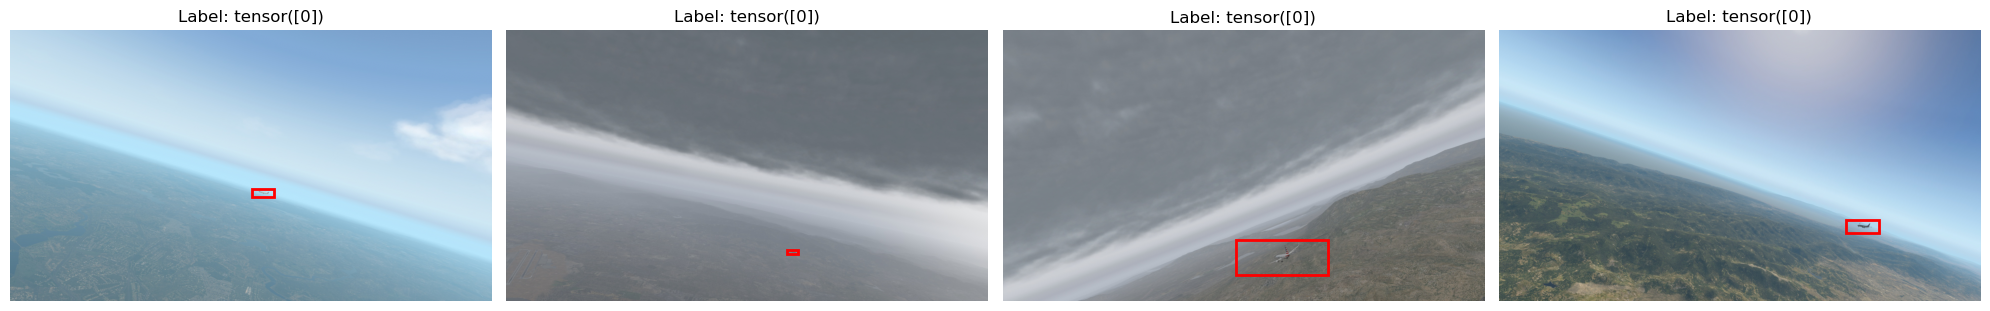

In [9]:
# test to check that new bboxes fit images
def visualize_samples(dataset, num_samples=4):
    """Visualize random images and their annotated bounding boxes in a row."""
    # Set the figure size
    fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))
    
    # Get random indices for images to display
    indices = random.sample(range(len(dataset)), num_samples)
    
    for i, ax in zip(indices, axs):
        image, target = dataset[i]
        img = F.to_pil_image(image)
        img = np.array(img) / 255.0  # Convert to numpy array and scale to [0, 1]
        ax.imshow(img)
        
        for box in target['boxes']:
            # Remember, box is in format [x_min, y_min, x_max, y_max]
            xmin, ymin, xmax, ymax = box
            # Create a Rectangle patch
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                     linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        # Add title and turn off axis
        ax.set_title(f"Label: {target['labels']}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize the samples
visualize_samples(train_aug_dataset)

